# Adversarial Schrodinger bridge

In [ ]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.49.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.2.0-cp310-cp310-manylinux_

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1
    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_),nn.BatchNorm1d(out_), nn.ReLU()])
    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
    return nn.Sequential(*modules)

In [ ]:
# Define of divergence's conjugate function
forward_kl_conjugate = lambda x: torch.exp(x - 1)
reverse_kl_conjugate = lambda x: -1 - torch.log(-x)
js_conjugate = lambda x: -torch.log(1 - torch.exp(x))

# Define of divergence's activation function
forward_kl_activation = lambda x: x
reverse_kl_activation = lambda x: -torch.exp(-x)
js_activation = lambda x: -torch.log(1 + torch.exp(-x))

# Divergences configuration
divergences = {'forward_kl': {'conj': forward_kl_conjugate, 'activ': forward_kl_activation},
               'reverse_kl': {'conj': reverse_kl_conjugate, 'activ': reverse_kl_activation},
               'js': {'conj': js_conjugate, 'activ': js_activation},
               }

In [ ]:
class fGAN(nn.Module):
    def __init__(self, dim, divergence='js'):
        super().__init__()
        assert divergence in divergences.keys() 

        self.dim = dim
        self.activation = divergences[divergence]['activ']
        self.conjugate = divergences[divergence]['conj']
        self.gen = get_simple_model([dim, 32, 32, 32, dim])
        self.disc = get_simple_model([dim, 32, 32, 32, 1])        

    def sample(self, latent):
        with torch.no_grad():
            samples = self.gen(latent)
        return samples.detach().cpu().numpy()

    


############## TEST ##################
test_dim = 2
f_gan = fGAN(test_dim)
f_gan.sample(torch.rand((4, test_dim))).shape

(4, 2)

In [ ]:
class Conditional(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = get_simple_model([in_dim, 32, 32, 32, 2 * latent_dim])

    def forward(self, x):
        return self.net(x).chunk(2, dim=1)
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 3
test_cond = Conditional(test_in_dim, test_latent_dim)
test_mu, test_log_std = test_cond(torch.rand((4, test_in_dim)))
test_mu.shape, test_log_std.shape

(torch.Size([4, 3]), torch.Size([4, 3]))

In [ ]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p, lr_gen=1e-4, lr_disc=1e-4, lr_cond=1e-4):
        self.batch_size = batch_size
        self.dim  = gan_q.dim

        self.gan_p = gan_p
        self.gan_q = gan_q

        self.conditional_p = conditional_p
        self.conditional_q = conditional_q

        self.marginal_q = marginal_q
        self.marginal_p = marginal_p

        # self.device = conditional_q.device
        self.optim_gen = torch.optim.Adam([{'params': gan_p.gen.parameters()},
                                            {'params': gan_q.gen.parameters()}], lr=lr_gen)
        self.optim_disc = torch.optim.Adam([{'params': gan_p.disc.parameters()},
                                            {'params': gan_q.disc.parameters()}], lr=lr_disc)
        self.optim_cond = torch.optim.Adam([{'params': conditional_p.parameters()},
                                            {'params': conditional_q.parameters()}], lr=lr_cond)
        
    def train(self, iterations):
        # avg_loss_gen_b, avg_loss_disc_b = 0, 0
        # avg_loss_gen_f, avg_loss_disc_f = 0, 0

        losses = {
            'forward': {'gen': [], 'disc': []},
            'backward': {'gen': [], 'disc': []}
        }

        for iteration in range(iterations):
            # Sample true data
            x = self.marginal_q.sample([self.batch_size, self.dim])
            y = self.marginal_p.sample([self.batch_size, self.dim])

            # Make backward step
            loss_gen_b, loss_disc_b = self._backward_step(y, x)
            losses['backward']['gen'].append(loss_gen_b)
            losses['backward']['disc'].append(loss_disc_b)

            # Make forward step
            loss_gen_f, loss_disc_f = self._forward_step(x, y)
            losses['forward']['gen'].append(loss_gen_f)
            losses['forward']['disc'].append(loss_disc_f)
            
            if iteration % 50 == 0:
                print(f'Iteration: {iteration}; forward: gen: {loss_gen_f}, disc: {loss_disc_f}; backward: gen: {loss_gen_b}, disc: {loss_disc_b}')
        return losses
        
    def _backward_step(self, y, x):
        loss_gen = self._train_step_gen(y, self.gan_p, self.conditional_p, self.conditional_q, self.marginal_q)
        loss_disc = self._train_step_disc(self.gan_p, y, x)
        return loss_gen, loss_disc

    def _forward_step(self, x, y):
        loss_gen = self._train_step_gen(x, self.gan_q, self.conditional_q, self.conditional_p, self.marginal_p)
        loss_disc = self._train_step_disc(self.gan_q, x, y)
        return loss_gen, loss_disc
    
    def _train_step_gen(self, latent, gan, cond, cond_fixed, marginal):
        self.optim_gen.zero_grad()
        self.optim_cond.zero_grad()

        # Generate samples
        samples = gan.gen(latent)

        # Generator loss
        loss_gen = -gan.activation(gan.disc(samples)).mean()
        
        # Condition distribution loss
        mu, log_std = cond(samples)
        cond_dist = Normal(mu, torch.exp(log_std))
        with torch.no_grad():
            mu_fixed, log_std_fixed = cond_fixed(latent)
            cond_fixed_dist = Normal(mu_fixed, torch.exp(log_std_fixed))

        loss_conditional = kl_divergence(cond_dist, cond_fixed_dist).mean()

        # Cross entropy loss
        loss_ce = -marginal.log_prob(samples).mean()
        
        loss = loss_gen + loss_conditional + loss_ce
        loss.backward()
        self.optim_gen.step()
        self.optim_cond.step()
        
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, gan, real, latent):
        self.optim_disc.zero_grad()

        # calc real loss
        pred_real = gan.disc(real)
        loss_real = gan.activation(pred_real).mean()

        # generated samples        
        with torch.no_grad():
            fake_samples = gan.gen(latent)
        pred_fake = gan.disc(fake_samples)
        loss_fake = gan.conjugate(gan.activation(pred_fake)).mean()

        # combine
        loss = loss_fake - loss_real
        loss.backward()
        self.optim_disc.step()
        return loss.detach().cpu().item()


# Experiments


## Unimodal experiments: 
1. $\pi_0(x) = \mathcal{N}(5, 1)$; $\pi_1(y) = \mathcal{N}(-2, 1)$
2. $\pi_0(x) = \mathcal{N}(0, 9)$; $\pi_1(y) = \mathcal{N}(20, 0.5^2)$

### Jense-Shannnon div

In [ ]:
gan_p = fGAN(1)
gan_q = fGAN(1)
conditional_p = Conditional(1, 32)
conditional_q = Conditional(1, 32)
marginal_q = Normal(5, 1)
marginal_p = Normal(-2, 1)

trainer = AdversarialIPFPTrainer(32, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p)
losses = trainer.train(5000)

Iteration: 0; forward: gen: 5.567203998565674, disc: 1.4206578731536865; backward: gen: 15.045125007629395, disc: 1.4004572629928589
Iteration: 50; forward: gen: 3.932807445526123, disc: 1.3531816005706787; backward: gen: 12.392641067504883, disc: 1.3878079652786255
Iteration: 100; forward: gen: 3.731691360473633, disc: 1.3399369716644287; backward: gen: 11.589470863342285, disc: 1.3654279708862305
Iteration: 150; forward: gen: 3.5221714973449707, disc: 1.3361897468566895; backward: gen: 11.00167179107666, disc: 1.3275864124298096
Iteration: 200; forward: gen: 3.3385627269744873, disc: 1.3052935600280762; backward: gen: 10.524876594543457, disc: 1.341975450515747
Iteration: 250; forward: gen: 3.178516387939453, disc: 1.2901792526245117; backward: gen: 10.024022102355957, disc: 1.3298617601394653
Iteration: 300; forward: gen: 2.9912872314453125, disc: 1.2639310359954834; backward: gen: 9.558289527893066, disc: 1.3126851320266724
Iteration: 350; forward: gen: 2.893632173538208, disc: 1.2

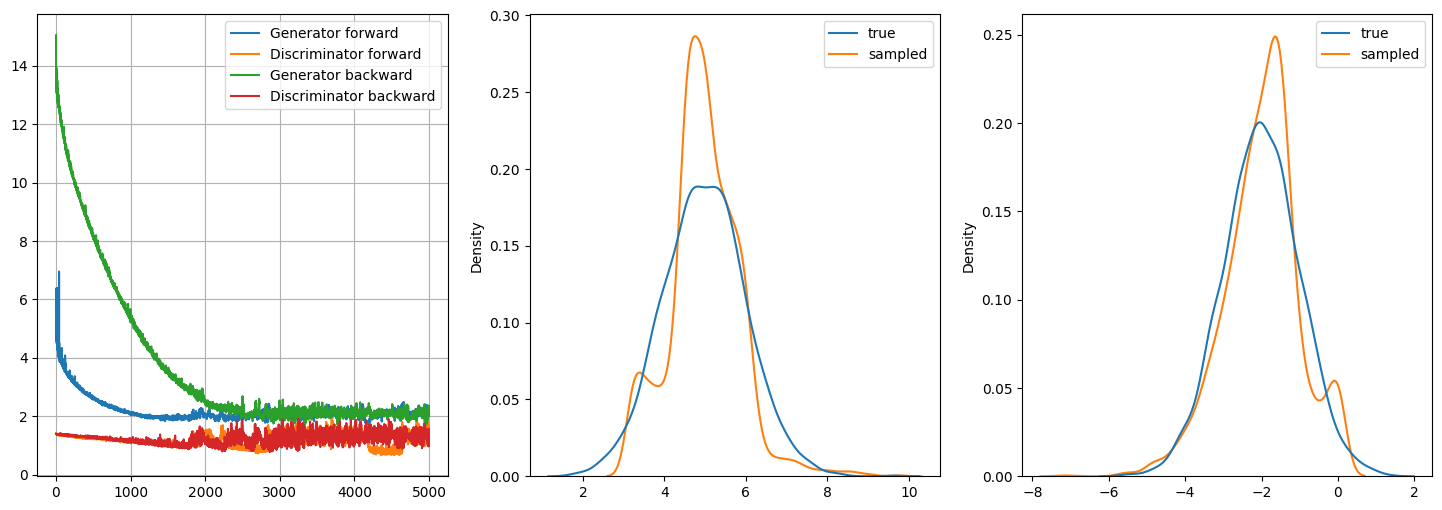

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot losses
axs[0].plot(losses['forward']['gen'], label='Generator forward')
axs[0].plot(losses['forward']['disc'], label='Discriminator forward')
axs[0].plot(losses['backward']['gen'], label='Generator backward')
axs[0].plot(losses['backward']['disc'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

# Plot samples 
n_samples = 2000
true_x = marginal_q.sample([n_samples, 1])
true_y = marginal_p.sample([n_samples, 1])

sampled_x = gan_p.sample(true_y)
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1])

sampled_y = gan_q.sample(true_x)
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[2])

plt.show()

### KL-divergence

In [ ]:
gan_p = fGAN(1, 'forward_kl')
gan_q = fGAN(1, 'forward_kl')
conditional_p = Conditional(1, 32)
conditional_q = Conditional(1, 32)
marginal_q = Normal(5, 1)
marginal_p = Normal(-2, 1)

trainer = AdversarialIPFPTrainer(32, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p)
losses = trainer.train(4000)

Iteration: 0; forward: gen: 5.3302001953125, disc: 0.6851273775100708; backward: gen: 13.829456329345703, disc: 0.3780667781829834
Iteration: 50; forward: gen: 4.340636253356934, disc: 0.5908280611038208; backward: gen: 12.545273780822754, disc: 0.25739359855651855
Iteration: 100; forward: gen: 3.891781806945801, disc: 0.5418280959129333; backward: gen: 11.701598167419434, disc: 0.18822205066680908
Iteration: 150; forward: gen: 3.450451374053955, disc: 0.4111766815185547; backward: gen: 11.121711730957031, disc: 0.1235705316066742
Iteration: 200; forward: gen: 3.216791868209839, disc: 0.38433194160461426; backward: gen: 10.508024215698242, disc: 0.05706071853637695
Iteration: 250; forward: gen: 2.914079189300537, disc: 0.30258098244667053; backward: gen: 9.994415283203125, disc: 0.013625264167785645
Iteration: 300; forward: gen: 2.6816565990448, disc: 0.18500342965126038; backward: gen: 9.474943161010742, disc: -0.0038412809371948242
Iteration: 350; forward: gen: 2.562268018722534, dis

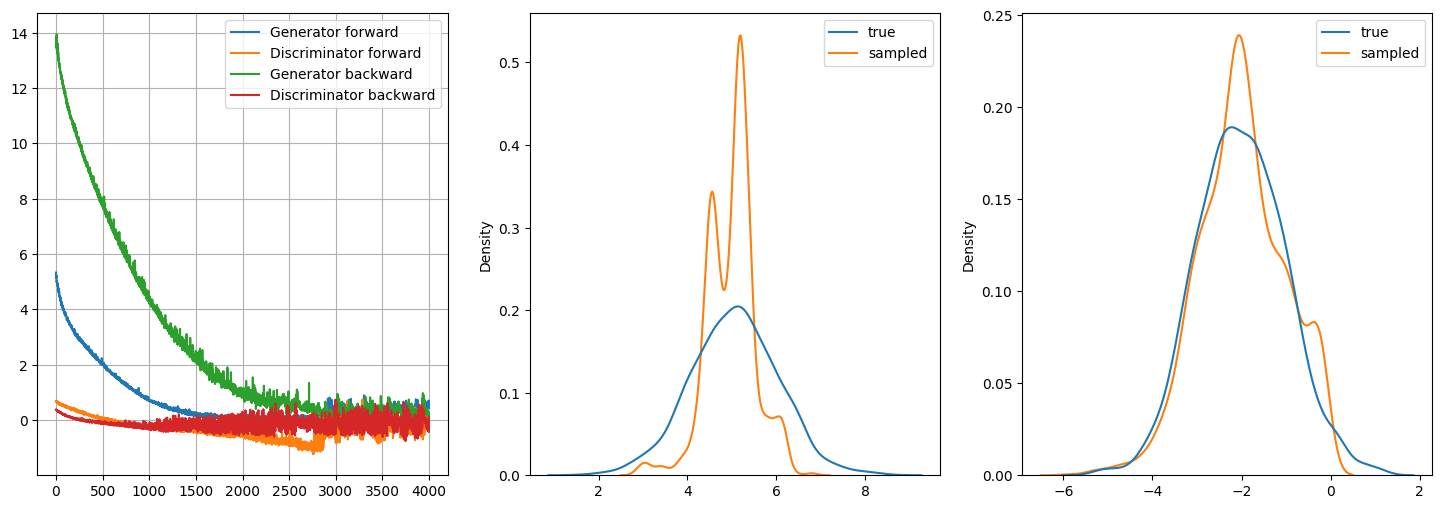

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot losses
axs[0].plot(losses['forward']['gen'], label='Generator forward')
axs[0].plot(losses['forward']['disc'], label='Discriminator forward')
axs[0].plot(losses['backward']['gen'], label='Generator backward')
axs[0].plot(losses['backward']['disc'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

# Plot samples 
n_samples = 2000
true_x = marginal_q.sample([n_samples, 1])
true_y = marginal_p.sample([n_samples, 1])

sampled_x = gan_p.sample(true_y)
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1])

sampled_y = gan_q.sample(true_x)
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[2])

plt.show()


## Multimodal experiment
3. $\pi_0(x) = \mathcal{N}(0, 1)$; $\pi_1(y) = \frac12 \mathcal{N}(20, 0.5^2) + \frac12 \mathcal{N}(-20, 0.5^2)$ 